<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_18298/1999621658.py:32: SyntaxWarning: invalid escape sequence '\d'
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract('(\d+)')
/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_18298/1999621658.py:33: SyntaxWarning: invalid escape sequence '\d'
  dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract('(\d+)')


Total number of unique restaurants: 2716
Final count of unique restaurants after remapping: 2716
Top 20 Cities by Number of Unique Restaurants (Deliveroo):
1. ANTWERPEN: 790
2. GENT: 452
3. LEUVEN: 242
4. BRUGGE: 226
5. KORTRIJK: 116
6. MECHELEN: 111
7. HASSELT: 80
8. UKKEL: 61
9. OOSTENDE: 57
10. SCHAARBEEK: 54
11. WATERLOO: 45
12. BRUSSEL: 42
13. SINT-LAMBRECHTS-WOLUWE: 37
14. ROESELARE: 36
15. JETTE: 35
16. AALST: 35
17. SINT-PIETERS-WOLUWE: 35
18. SINT-NIKLAAS: 29
19. EVERE: 26
20. GENK: 24
21. TURNHOUT: 17
22. VILVOORDE: 16
23. SINT-AGATHA-BERCHEM: 15
24. SINT-TRUIDEN: 14
25. KRAAINEM: 13
26. VORST: 13
27. SINT-JANS-MOLENBEEK: 11
28. DENDERMONDE: 11
29. GANSHOREN: 9
30. MORTSEL: 8
31. OUDERGEM: 6
32. GRIMBERGEN: 6
33. DROGENBOS: 5
34. WIJNEGEM: 4
35. WEMMEL: 4
36. ZAVENTEM: 3
37. SCHOTEN: 3
38. SINT-PIETERS-LEEUW: 3
39. MACHELEN: 3
40. WEZEMBEEK-OPPEM: 2
41. KNOKKE-HEIST: 2
42. DILBEEK: 2
43. DESTELBERGEN: 1
44. WOMMELGEM: 1
45. BIERBEEK: 1
46. BORSBEEK: 1
47. OUD-TURNHOUT: 1
48. 

/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_18298/1999621658.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract('(\d+)')


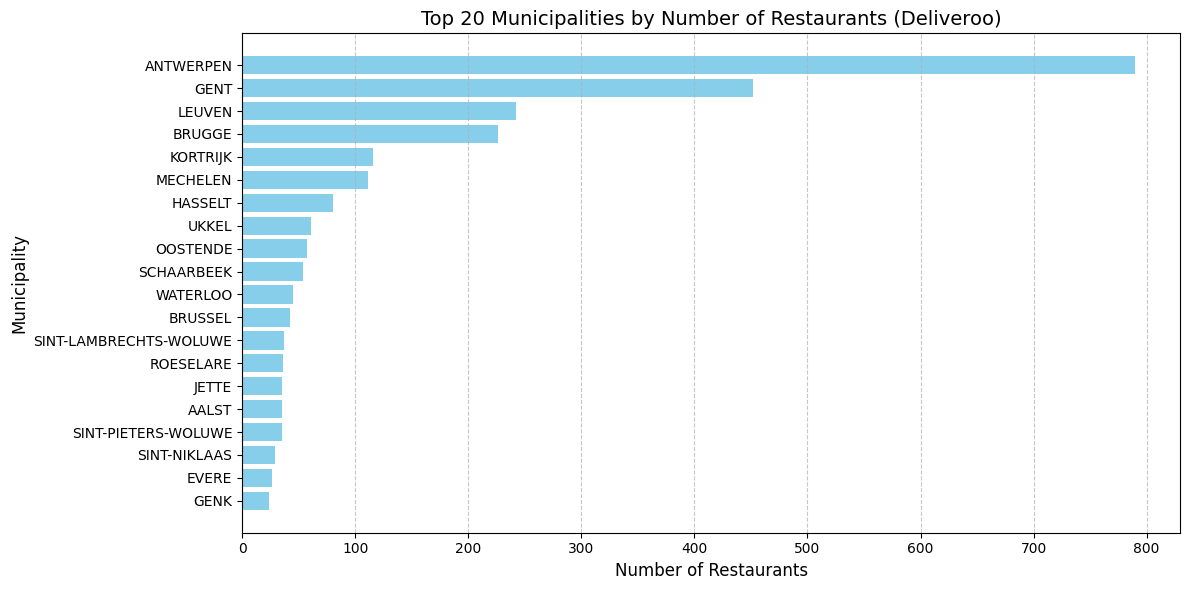

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/deliveroo.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"

# Count unique restaurants from the database
conn = sqlite3.connect(db_path)
restaurant_count_query = """
    SELECT 
        r.id AS restaurant_id,
        r.postal_code AS postal_code,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.id;
"""
restaurant_data = pd.read_sql_query(restaurant_count_query, conn)
conn.close()

# Remove duplicates to get the accurate count
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Normalize and clean postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract('(\d+)')
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract('(\d+)')

# Remap missing or '0' locations using the postal code from the external CSV
remapped_restaurants_df = pd.merge(
    unique_restaurants,
    dutch_postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Deduplicate to ensure unique restaurant IDs
remapped_restaurants_df = remapped_restaurants_df.drop_duplicates(subset=['restaurant_id'])

# Replace missing or '0' location names with the MAIN MUNICIPALITY from postal codes
remapped_restaurants_df['location_name'] = remapped_restaurants_df['location_name'].fillna(remapped_restaurants_df['MAIN MUNICIPALITY'])
remapped_restaurants_df.drop(columns=['Postcode'], inplace=True)

# Final count of unique restaurants
final_restaurant_count = len(remapped_restaurants_df)
print(f"Final count of unique restaurants after remapping: {final_restaurant_count}")

# Group by municipality and count restaurants
restaurants_per_municipality = remapped_restaurants_df.groupby('MAIN MUNICIPALITY')['restaurant_id'].count().reset_index()
restaurants_per_municipality.columns = ['Municipality', 'Restaurant Count']
restaurants_per_municipality = restaurants_per_municipality.sort_values(by='Restaurant Count', ascending=False)

# Display top 20 municipalities by restaurant count
print("Top 20 Cities by Number of Unique Restaurants (Deliveroo):")
for idx, (municipality, count) in enumerate(zip(restaurants_per_municipality['Municipality'], restaurants_per_municipality['Restaurant Count']), start=1):
    print(f"{idx}. {municipality}: {count}")

top_20_municipalities = restaurants_per_municipality.head(20)

# Plot the top 20 municipalities
plt.figure(figsize=(12, 6))
plt.barh(top_20_municipalities['Municipality'], top_20_municipalities['Restaurant Count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 20 Municipalities by Number of Restaurants (Deliveroo)', fontsize=14)
plt.gca().invert_yaxis()  # Highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the chart
plt.show()


Total number of restaurants before the merge: 4071

Entries with Unknown Region:
Empty DataFrame
Columns: [postal_code, city, restaurant_count]
Index: []
Total count of restaurants in Unknown Region: 0
Total number of unique postal codes in Unknown Region: 0
Exported unknown region data to 'unknown_region_data.csv'.
Total number of restaurants after computing province and region: 4071

Top 20 Locations by Number of Unique Restaurants (Takeaway):
                    city  restaurant_count
0              Antwerpen               437
1                   Gent               309
2              Bruxelles               264
3                 Leuven               174
4             Schaerbeek               110
5                 Brugge                96
6               Oostende                85
7               Mechelen                84
8             Anderlecht                84
9                 Deurne                56
10                 Uccle                51
11               Ixelles          

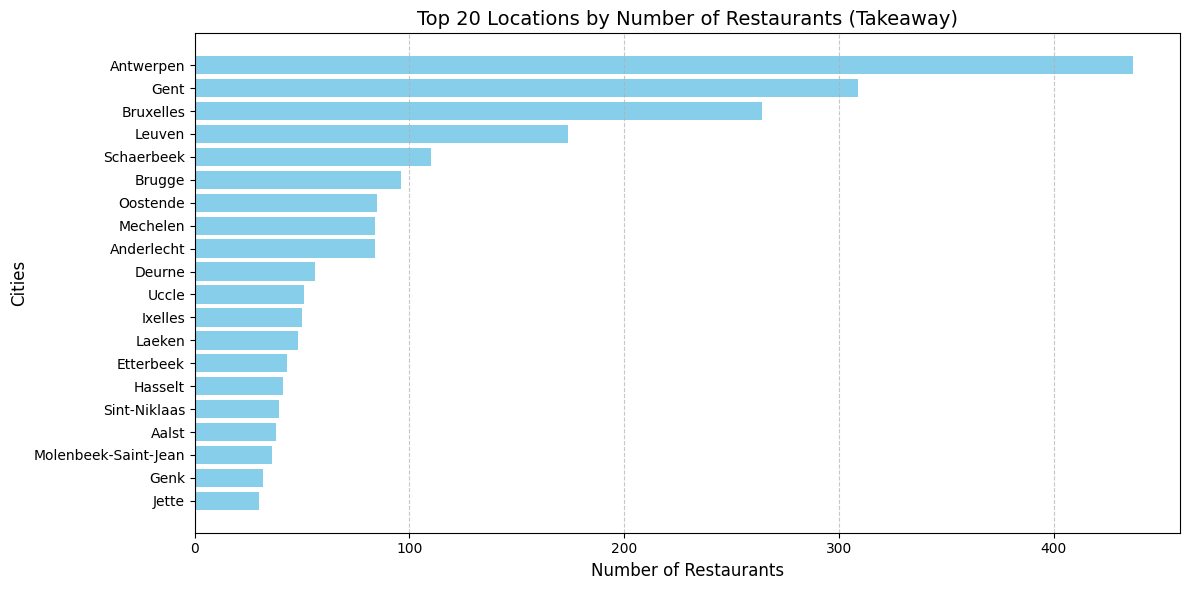

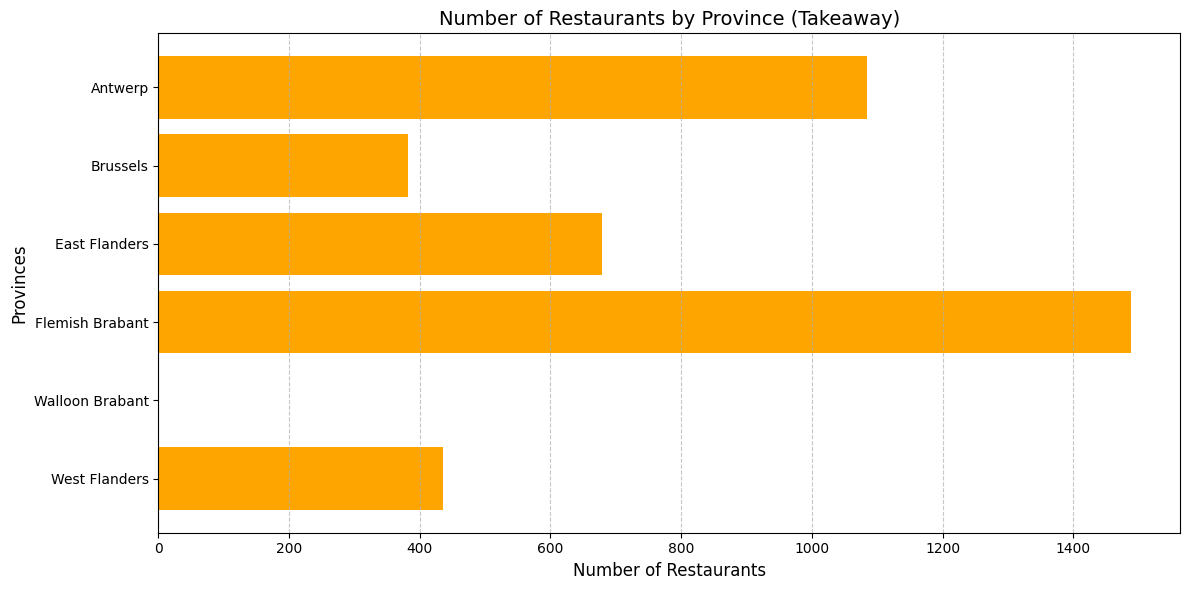

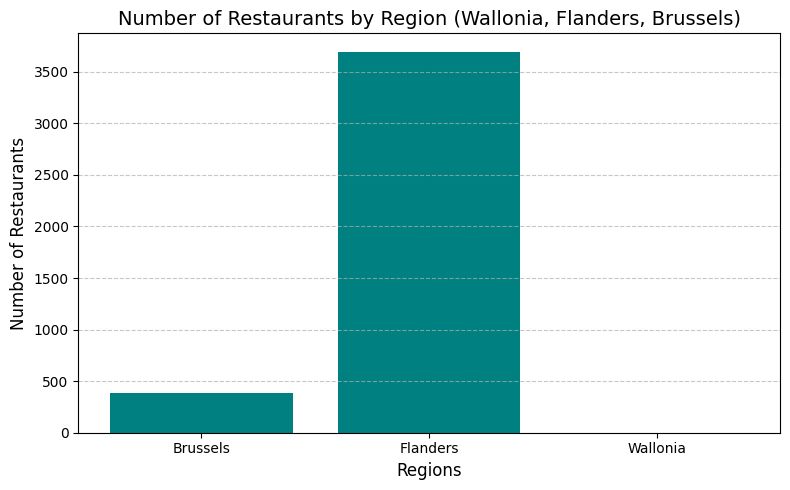

In [2]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

# File paths
db_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'

# Step 1: Connect to the database
con = sqlite3.connect(db_path)

# Step 2: SQL query to include city and postalCode
takeaway_restaurant_distribution = """
    SELECT 
        l.postalCode AS postal_code,
        r.city AS city,
        COUNT(DISTINCT r.restaurant_id) AS restaurant_count
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    GROUP BY r.city
    ORDER BY restaurant_count DESC;
"""

# Execute the query and fetch results
t_distribution_results = pd.read_sql_query(takeaway_restaurant_distribution, con)
con.close()

# Step 3: Count before the merge
print(f"Total number of restaurants before the merge: {t_distribution_results['restaurant_count'].sum()}")

# Step 4: Define postal code to province mapping
def assign_province(postal_code):
        try:
            postal_code = int(postal_code)
            if 1000 <= postal_code <= 1299:
                return 'Brussels'
            elif 1300 <= postal_code <= 1499:
                return 'Walloon Brabant'
            elif 1500 <= postal_code <= 1999:
                return 'Flemish Brabant'
            elif 2000 <= postal_code <= 2999:
                return 'Antwerp'
            elif 3000 <= postal_code <= 3999:
                return 'Flemish Brabant'
            elif 4000 <= postal_code <= 4999:
                return 'Liège'
            elif 5000 <= postal_code <= 5999:
                return 'Namur'
            elif 6000 <= postal_code <= 6599:
                return 'Hainaut'
            elif 6600 <= postal_code <= 6999:
                return 'Luxembourg'
            elif 7000 <= postal_code <= 7999:
                return 'Hainaut'
            elif 8000 <= postal_code <= 8999:
                return 'West Flanders'
            elif 9000 <= postal_code <= 9999:
                return 'East Flanders'
            else:
                return 'Unknown'
        except (ValueError, TypeError):
            return 'Unknown'
# Define postal code ranges for regions
def assign_region(Province):
    Brussels = ['Brussels']
    Flanders = ['Antwerp', 'Flemish Brabant', 'East Flanders', 'West Flanders', 'Limburg']
    Wallonia = ['Walloon Brabant', 'Hainaut', 'Liège', 'Luxembourg', 'Namur']
    if Province is None:
        return None
    
    if Province in Brussels:
        return 'Brussels'
    elif Province in Flanders:
        return 'Flanders'
    elif Province in Wallonia:
        return 'Wallonia'
    return 'Unknown'

# Normalize postal codes
t_distribution_results['postal_code'] = t_distribution_results['postal_code'].astype(str).str.extract(r'(\d+)')

# Step 5: Compute province and region
t_distribution_results['Province'] = t_distribution_results['postal_code'].apply(assign_province)
t_distribution_results['Region'] = t_distribution_results['Province'].apply(assign_region)

# Step 6: Identify missing or unknown regions
unknown_region_data = t_distribution_results[t_distribution_results['Region'] == 'Unknown']
print("\nEntries with Unknown Region:")
print(unknown_region_data[['postal_code', 'city', 'restaurant_count']].head(10))  # Display first 10 rows
print(f"Total count of restaurants in Unknown Region: {unknown_region_data['restaurant_count'].sum()}")
print(f"Total number of unique postal codes in Unknown Region: {unknown_region_data['postal_code'].nunique()}")

# Export unknown region data to CSV
unknown_region_data.to_csv('unknown_region_data.csv', index=False)
print("Exported unknown region data to 'unknown_region_data.csv'.")

# Step 7: Group by province and calculate restaurant counts
province_grouped = t_distribution_results.groupby('Province', as_index=False)['restaurant_count'].sum()

# Step 8: Group by region and calculate restaurant counts
region_grouped = t_distribution_results.groupby('Region', as_index=False)['restaurant_count'].sum()

# Step 9: Count after computing province and region
print(f"Total number of restaurants after computing province and region: {t_distribution_results['restaurant_count'].sum()}")

# Step 10: Display the top 20 locations
top_20_locations = t_distribution_results.sort_values(by='restaurant_count', ascending=False).head(20)
print("\nTop 20 Locations by Number of Unique Restaurants (Takeaway):")
print(top_20_locations[['city', 'restaurant_count']])

# Step 11: Create the bar chart for the top 20 locations
plt.figure(figsize=(12, 6))
plt.barh(top_20_locations['city'], top_20_locations['restaurant_count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Cities', fontsize=12)
plt.title('Top 20 Locations by Number of Restaurants (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 12: Create the bar chart for provinces
plt.figure(figsize=(12, 6))
plt.barh(province_grouped['Province'], province_grouped['restaurant_count'], color='orange')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Provinces', fontsize=12)
plt.title('Number of Restaurants by Province (Takeaway)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 13: Create the bar chart for regions
plt.figure(figsize=(8, 5))
plt.bar(region_grouped['Region'], region_grouped['restaurant_count'], color='teal')
plt.xlabel('Regions', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.title('Number of Restaurants by Region (Wallonia, Flanders, Brussels)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Total number of restaurant rows in the raw database: 2729
Initial count of unique restaurant IDs: 2729

Rows with missing city values:
     city                         restaurant_id  \
435        b4f0e280-51c0-5a4c-aec1-72ae20ab81eb   
476        00ec3913-3a38-4b4b-b025-faaaa24a45c1   
926        ec3f1b8d-2998-5aab-81fe-2afbfd0549d6   
1570       db3071d0-f7ac-4ca5-9e06-a6be04b00ec0   
1672       e2505de4-c708-4652-b009-048773c7bd72   
1975       e2834ec8-f4a3-4a7f-9c95-8564a859c38d   
2386       a473f47e-ca45-5e4c-b968-790ee038593b   
2540       e1897b35-37e9-41d7-bf7e-e79c102b32ff   

                                                address postal_code  
435        Diestsesteenweg 215, Kermt, Limburg, 3540 ,         None  
476   Vital Decosterstraat 16, Leuven, Flemish Regio...        None  
926      Autoroute E40 - Brussel, Dilbeek, Emea, 1702,         None  
1570                       Sint-Jobsesteenweg 759, 1180        None  
1672                                 Houtbriel 25, 9100

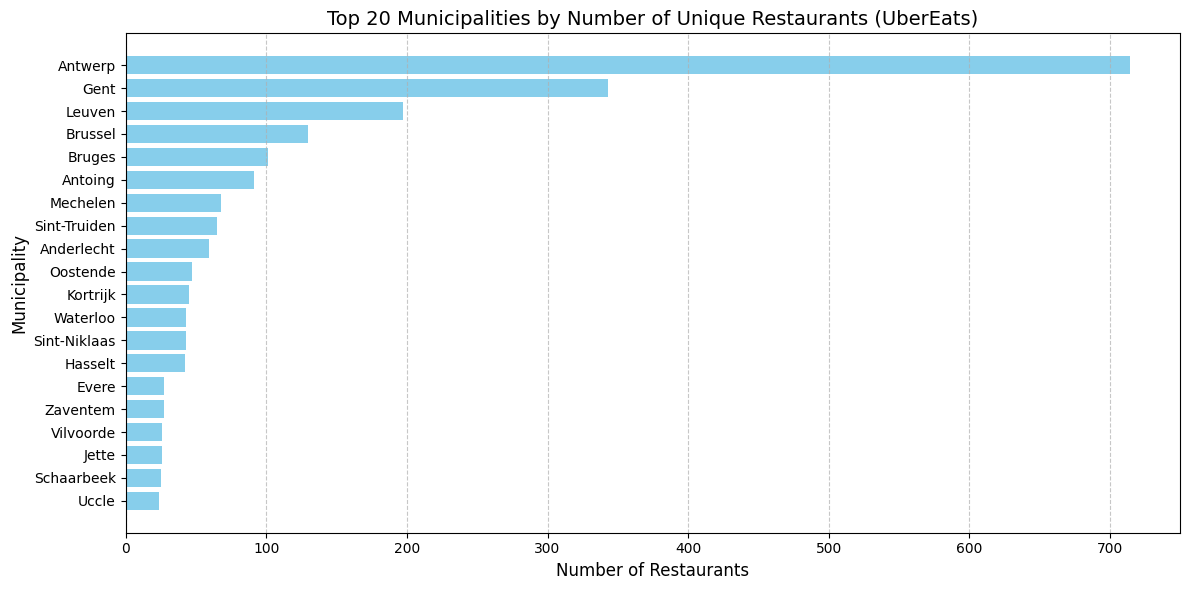

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz

# File paths
db_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/ubereats.db'
csv_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls'

# Connect to the UberEats database
conn = sqlite3.connect(db_path)

# Step 1: Count total restaurants directly from the database
total_restaurants_query = """
    SELECT COUNT(*) AS total_restaurants
    FROM restaurants;
"""
total_restaurants_sql = pd.read_sql_query(total_restaurants_query, conn).iloc[0, 0]

# Query to extract relevant data
uber_restaurant_query = """
    SELECT 
        location__city AS city,
        id AS restaurant_id,
        location__address AS address,
        location__postal_code AS postal_code
    FROM restaurants;
"""
uber_restaurant_data = pd.read_sql_query(uber_restaurant_query, conn)

# Close the connection
conn.close()

# Print initial counts
print(f"Total number of restaurant rows in the raw database: {total_restaurants_sql}")
print(f"Initial count of unique restaurant IDs: {uber_restaurant_data['restaurant_id'].nunique()}")

# Load the external CSV with municipalities
municipality_data = pd.read_excel(csv_path)

# Step 2: Fix missing city data
missing_city_data = uber_restaurant_data[uber_restaurant_data['city'].isnull() | (uber_restaurant_data['city'].str.strip() == '')]
print("\nRows with missing city values:")
print(missing_city_data)

# Correct specific missing city values based on the provided mapping
manual_city_corrections = {
    435: 'Limburg',
    476: 'Leuven',
    926: 'Brussels',
    1570: 'Sint-Jobsesteenweg',
    1672: 'Houtbriel',
    1975: 'Hasselt',
    2386: 'Antwerp',
    2540: 'Antwerp'
}

# Apply the corrections
for idx, city in manual_city_corrections.items():
    uber_restaurant_data.loc[idx, 'city'] = city

# Step 3: Normalize and clean the columns for matching
uber_restaurant_data['city'] = uber_restaurant_data['city'].str.strip().str.lower()
municipality_data['NAME'] = municipality_data['NAME'].str.strip().str.lower()
municipality_data['MAIN MUNICIPALITY'] = municipality_data['MAIN MUNICIPALITY'].str.strip().str.lower()

# Step 4: Map cities to municipalities using RapidFuzz
def map_city_to_municipality(city, municipality_names):
    if pd.isna(city):
        return None
    result = process.extractOne(city, municipality_names, scorer=fuzz.ratio)
    if result is not None:
        match, score, _ = result
        if score >= 80:  # Use 80% similarity as a threshold
            return match
    return None

municipality_names = municipality_data['NAME'].unique()
uber_restaurant_data['mapped_municipality'] = uber_restaurant_data['city'].apply(
    map_city_to_municipality, args=(municipality_names,)
)

# Join the matched municipalities with the main municipality column
uber_restaurant_data = pd.merge(
    uber_restaurant_data,
    municipality_data[['NAME', 'MAIN MUNICIPALITY']],
    left_on='mapped_municipality',
    right_on='NAME',
    how='left'
)

# Replace missing mapped municipalities with the original city values
uber_restaurant_data['final_municipality'] = uber_restaurant_data['MAIN MUNICIPALITY'].fillna(uber_restaurant_data['city'])

# Step 5: Normalize naming
city_mapping = {
    'antwerpen': 'antwerp',
    'antwerp': 'antwerp',
    'gent': 'gent',
    'ghent': 'gent',
    'bruxelles': 'brussels',
    'brussels': 'brussels',
    'brugge': 'bruges',
    'bruges': 'bruges',
    'louvain': 'leuven',
    'leuven': 'leuven',
    'uccle': 'uccle',
    'ukkle': 'uccle',
    'uccle / ukkel': 'uccle',
    'Knocke-Heist': 'Knokke-Heist'
}
uber_restaurant_data['final_municipality'] = uber_restaurant_data['final_municipality'].replace(city_mapping)

# Step 6: Remove duplicates based on restaurant_id
uber_restaurant_data = uber_restaurant_data.drop_duplicates(subset=['restaurant_id'])

# Step 7: Count total unique restaurants after processing
total_restaurants_processed = uber_restaurant_data['restaurant_id'].nunique()

# Print comparison
print("\nFinal Counts:")
print(f"Total number of rows in raw SQL database: {total_restaurants_sql}")
print(f"Total unique restaurants before processing: {uber_restaurant_data['restaurant_id'].nunique()}")
print(f"Total unique restaurants after processing: {total_restaurants_processed}")

# Step 8: Group by final municipality and count unique restaurants
restaurants_per_municipality = (
    uber_restaurant_data.groupby('final_municipality')['restaurant_id']
    .count()
    .reset_index()
    .rename(columns={'restaurant_id': 'Restaurant Count'})
    .sort_values(by='Restaurant Count', ascending=False)
)

# Step 9: Print the top 20 municipalities for analysis
print("\nTop 20 Municipalities by Number of Unique Restaurants (UberEats):")
for idx, (municipality, count) in enumerate(
    zip(restaurants_per_municipality['final_municipality'], restaurants_per_municipality['Restaurant Count']), start=1
):
    print(f"{idx}. {municipality.title()}: {count}")

# Step 10: Plot the top 20 municipalities
top_20_municipalities = restaurants_per_municipality.head(20)
plt.figure(figsize=(12, 6))
plt.barh(top_20_municipalities['final_municipality'].str.title(), top_20_municipalities['Restaurant Count'], color='skyblue')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 20 Municipalities by Number of Unique Restaurants (UberEats)', fontsize=14)
plt.gca().invert_yaxis()  # Highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Total number of unique restaurants: 2716


/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_18298/1670028753.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract(r'(\d+)')


Final count of unique restaurants after remapping: 2716
Top Municipalities with Vegetarian Data:
              Municipality  Restaurant Count  Veg Restaurant Count  \
1                ANTWERPEN               790                   135   
14                    GENT               452                   100   
23                  LEUVEN               242                    45   
4                   BRUGGE               226                    46   
21                KORTRIJK               116                    19   
26                MECHELEN               111                    18   
16                 HASSELT                80                    12   
45                   UKKEL                61                     5   
28                OOSTENDE                57                    13   
33              SCHAARBEEK                54                     3   
48                WATERLOO                45                     5   
5                  BRUSSEL                42                   

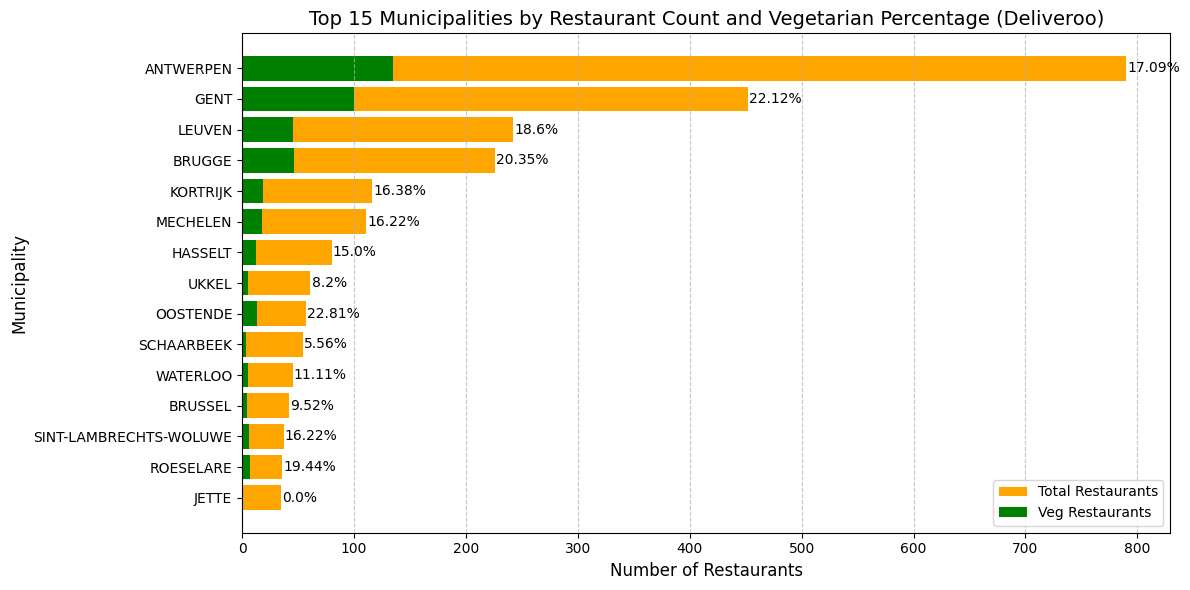

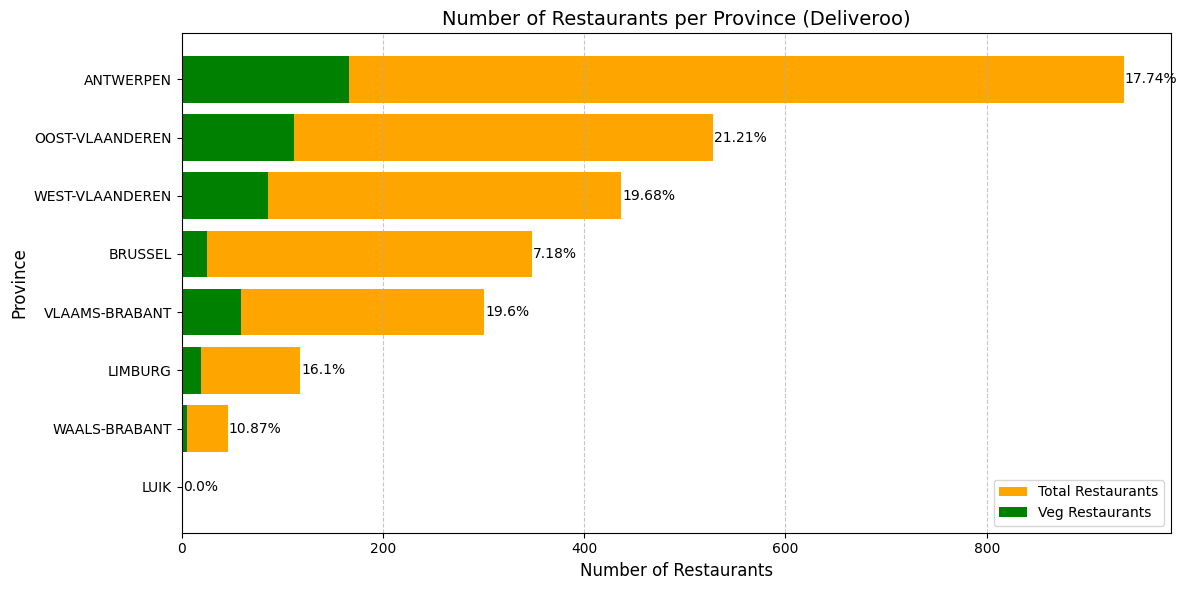

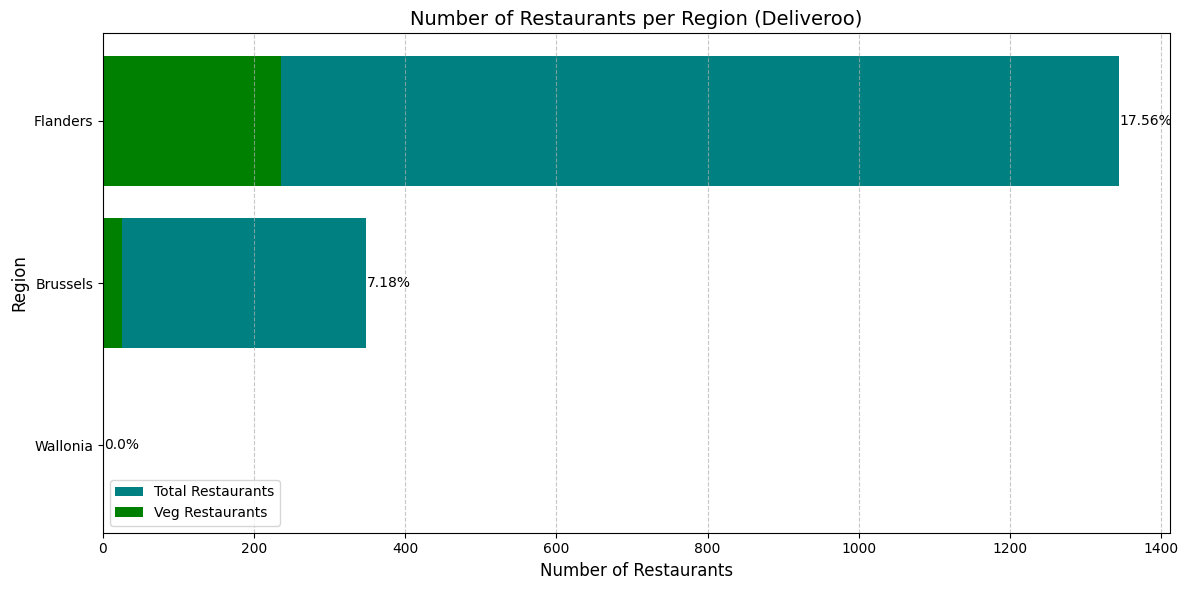

NameError: name 'veg_dish_mapped' is not defined

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/deliveroo.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"

# Count unique restaurants from the database
conn = sqlite3.connect(db_path)
restaurant_count_query = """
    SELECT 
        r.id AS restaurant_id,
        r.postal_code AS postal_code,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.id;
"""
restaurant_data = pd.read_sql_query(restaurant_count_query, conn)

# Query to extract vegetarian and vegan dishes with postal codes from the restaurant table for Deliveroo
veg_dish_query = """
SELECT
    r.id AS restaurant_id,
    r.postal_code AS postal_code,
    r.name AS restaurant_name,
    r.address AS restaurant_address,
    mi.name AS dish_name,
    mi.description,
    c.name AS category
FROM
    menu_items mi
JOIN
    categories c ON mi.categorie_id = c.categorie_id
JOIN
    restaurants r ON mi.restaurant_id = r.id
WHERE
    c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%' OR c.name LIKE '%veg%';
"""
veg_dish_data = pd.read_sql_query(veg_dish_query, conn)
conn.close()

# Remove duplicates to get the accurate count
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Normalize and clean postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract(r'(\d+)')
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract(r'(\d+)')
veg_dish_data['postal_code'] = veg_dish_data['postal_code'].astype(str).str.extract(r'(\d+)')

# Remap missing or '0' locations using the external CSV
remapped_restaurants_df = pd.merge(
    unique_restaurants,
    dutch_postal_codes_df[['Postcode', 'NAME', 'MAIN MUNICIPALITY', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Deduplicate to ensure unique restaurant IDs
remapped_restaurants_df = remapped_restaurants_df.drop_duplicates(subset=['restaurant_id'])

# Replace missing or '0' location names
remapped_restaurants_df['location_name'] = remapped_restaurants_df['location_name'].fillna(remapped_restaurants_df['NAME'])
remapped_restaurants_df.drop(columns=['Postcode', 'NAME'], inplace=True)

# Final count of unique restaurants
final_restaurant_count = len(remapped_restaurants_df)
print(f"Final count of unique restaurants after remapping: {final_restaurant_count}")

# Group by municipality and count restaurants
restaurants_per_municipality = remapped_restaurants_df.groupby('MAIN MUNICIPALITY')['restaurant_id'].count().reset_index()
restaurants_per_municipality.columns = ['Municipality', 'Restaurant Count']

# Map vegetarian and vegan dishes to municipalities
veg_dishes_per_municipality = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('MAIN MUNICIPALITY')['restaurant_id'].nunique().reset_index()
veg_dishes_per_municipality.columns = ['Municipality', 'Veg Restaurant Count']

# Combine municipality restaurant and vegetarian data
municipality_comparison_df = pd.merge(
    restaurants_per_municipality,
    veg_dishes_per_municipality,
    on='Municipality',
    how='left'
)
municipality_comparison_df['Veg Restaurant Count'] = municipality_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
municipality_comparison_df['Percentage Veg'] = (municipality_comparison_df['Veg Restaurant Count'] / municipality_comparison_df['Restaurant Count'] * 100).round(2)
municipality_comparison_df = municipality_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Print top municipalities with data
print("Top Municipalities with Vegetarian Data:")
print(municipality_comparison_df.head(15))

# Plot bar chart for top 15 municipalities
top_15_municipalities = municipality_comparison_df.head(15)
plt.figure(figsize=(12, 6))
bars = plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Restaurant Count'], color='orange', label='Total Restaurants')
plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, top_15_municipalities['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 15 Municipalities by Restaurant Count and Vegetarian Percentage (Deliveroo)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Group by province and count restaurants
restaurants_per_province = remapped_restaurants_df.groupby('Provincie')['restaurant_id'].count().reset_index()
restaurants_per_province.columns = ['Province', 'Restaurant Count']

# Map vegetarian and vegan dishes to provinces
veg_dishes_per_province = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('Provincie')['restaurant_id'].nunique().reset_index()
veg_dishes_per_province.columns = ['Province', 'Veg Restaurant Count']

# Combine province restaurant and vegetarian data
province_comparison_df = pd.merge(
    restaurants_per_province,
    veg_dishes_per_province,
    on='Province',
    how='left'
)
province_comparison_df['Veg Restaurant Count'] = province_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
province_comparison_df['Percentage Veg'] = (province_comparison_df['Veg Restaurant Count'] / province_comparison_df['Restaurant Count'] * 100).round(2)
province_comparison_df = province_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Plot bar chart for restaurants per province with vegetarian data
plt.figure(figsize=(12, 6))
bars = plt.barh(province_comparison_df['Province'], province_comparison_df['Restaurant Count'], color='orange', label='Total Restaurants')
plt.barh(province_comparison_df['Province'], province_comparison_df['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, province_comparison_df['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Province', fontsize=12)
plt.title('Number of Restaurants per Province (Deliveroo)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Add regions based on postal codes (Flanders, Brussels, Wallonia)
def assign_region(postal_code):
    if pd.notnull(postal_code):
        postal_code = int(postal_code)
        if 1000 <= postal_code <= 1299:
            return 'Brussels'
        elif 1300 <= postal_code <= 1499 or 2000 <= postal_code <= 3999:
            return 'Flanders'
        elif 4000 <= postal_code <= 7999:
            return 'Wallonia'
    return None

remapped_restaurants_df['Region'] = remapped_restaurants_df['postal_code'].apply(assign_region)

# Group by region and count restaurants
restaurants_per_region = remapped_restaurants_df.groupby('Region')['restaurant_id'].count().reset_index()
restaurants_per_region.columns = ['Region', 'Restaurant Count']

# Map vegetarian and vegan dishes to regions
veg_dishes_per_region = pd.merge(
    veg_dish_data,
    remapped_restaurants_df[['postal_code', 'Region']],
    on='postal_code',
    how='left'
).groupby('Region')['restaurant_id'].nunique().reset_index()
veg_dishes_per_region.columns = ['Region', 'Veg Restaurant Count']

# Combine region restaurant and vegetarian data
region_comparison_df = pd.merge(
    restaurants_per_region,
    veg_dishes_per_region,
    on='Region',
    how='left'
)
region_comparison_df['Veg Restaurant Count'] = region_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
region_comparison_df['Percentage Veg'] = (region_comparison_df['Veg Restaurant Count'] / region_comparison_df['Restaurant Count'] * 100).round(2)
region_comparison_df = region_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Plot bar chart for restaurants per region with vegetarian data
plt.figure(figsize=(12, 6))
bars = plt.barh(region_comparison_df['Region'], region_comparison_df['Restaurant Count'], color='teal', label='Total Restaurants')
plt.barh(region_comparison_df['Region'], region_comparison_df['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, region_comparison_df['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title('Number of Restaurants per Region (Deliveroo)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Export vegetarian data to CSV
veg_dish_data_export = veg_dish_mapped[['restaurant_id', 'postal_code', 'restaurant_name', 'restaurant_address', 'dish_name', 'category', 'MAIN MUNICIPALITY']]
veg_dish_data_export.to_csv("veg_dishes_with_restaurants_and_municipality.csv", index=False)
print("Vegetarian dish data with restaurant details and municipality exported to 'veg_dishes_with_restaurants_and_municipality.csv'.")

Restaurant Duplicate Files :                             slug_id restaurant_id  postal_code  \
5       pizza-hut-delivery-houthalen      0307RP11         3530   
6       pizza-hut-delivery-houthalen      0307RP11         3530   
7       pizza-hut-delivery-houthalen      0307RP11         3530   
8       pizza-hut-delivery-houthalen      0307RP11         3530   
9       pizza-hut-delivery-houthalen      0307RP11         3530   
...                              ...           ...          ...   
157804                         titis      RR3Q15QN         1750   
157805                         titis      RR3Q15QN         1674   
157806                         titis      RR3Q15QN         1500   
157807                         titis      RR3Q15QN         1755   
157808                         titis      RR3Q15QN         9400   

                 location_name  
5           Sint-Lambertuskerk  
6            Sint-Martinuskerk  
7       Sint-Jozef Werkmankerk  
8               Sint-Trudokerk  
9 

/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_23682/368968588.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].apply(lambda x: str(x).strip() if pd.notnull(x) else '')
/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_23682/368968588.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].str.extract(r'(\d+)', expand=False)


Final count of unique restaurants after remapping: 4071
Top Municipalities with Vegetarian Data:
           Municipality  Restaurant Count  Veg Restaurant Count  \
5             ANTWERPEN               562                   138   
52                 GENT               338                    92   
46                EVERE               250                    24   
39              DILBEEK               202                     8   
175           VILVOORDE               177                    12   
190            ZAVENTEM               108                    18   
118            MECHELEN               106                    22   
112             LUBBEEK                77                    18   
26              BREDENE                74                    16   
28               BRUGGE                73                    25   
41            DROGENBOS                63                     9   
63              HASSELT                61                    12   
160  SINT-PIETERS-LEEUW         

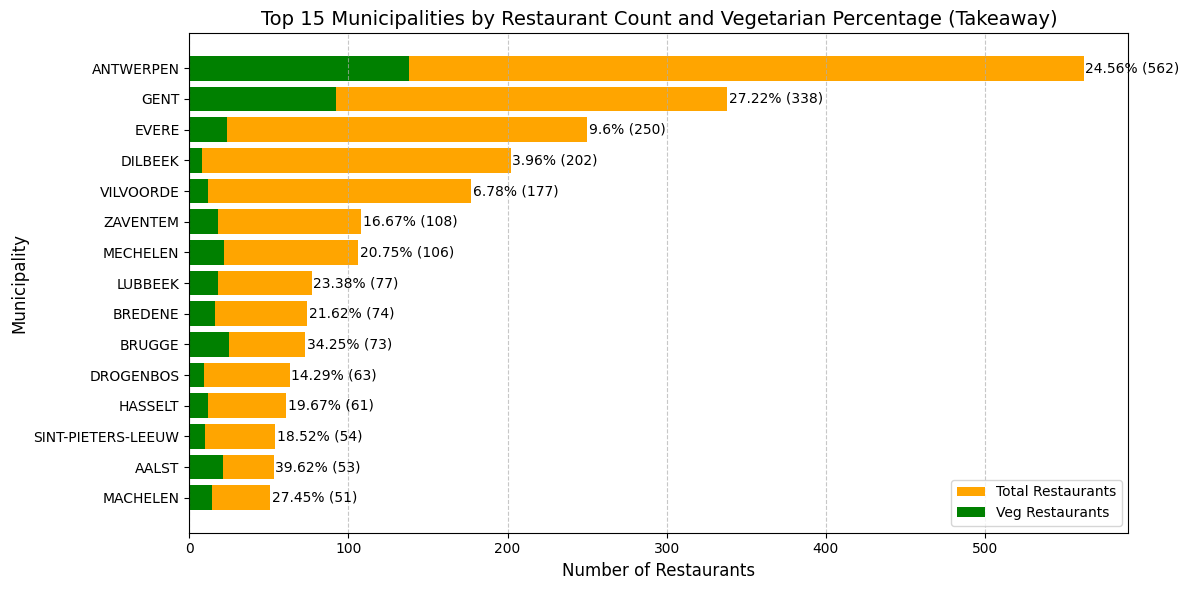

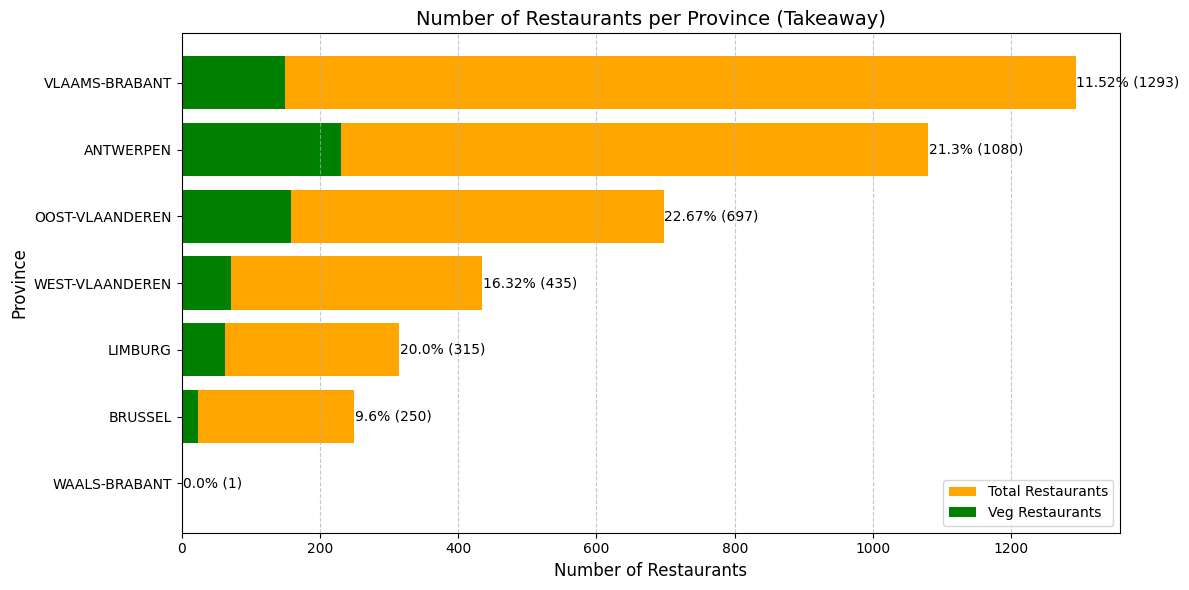

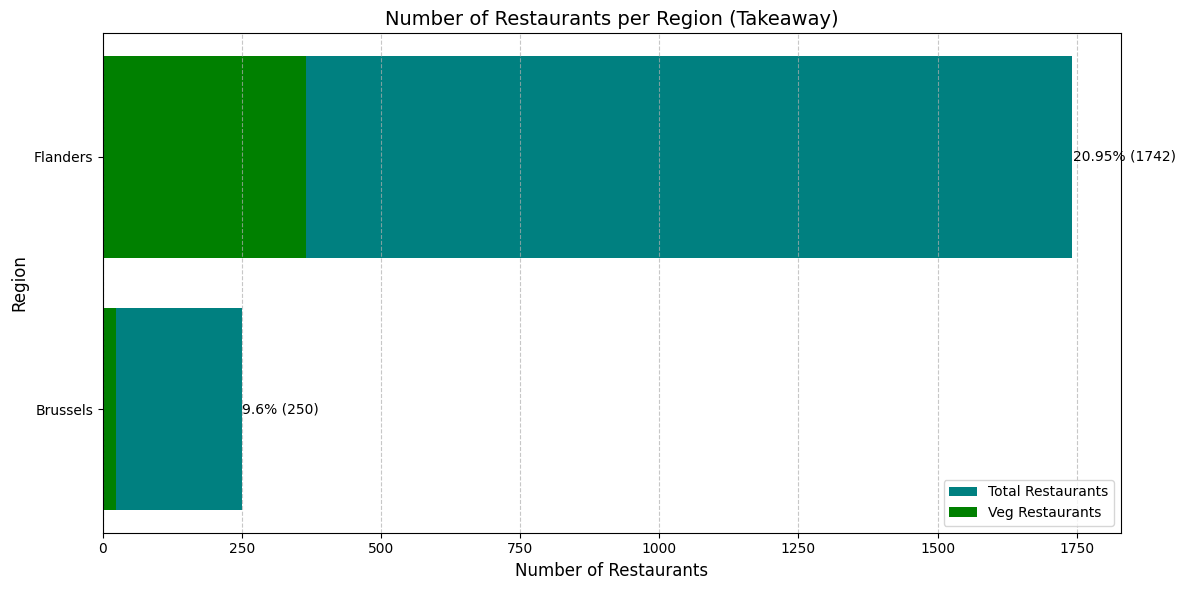

KeyError: 'restaurant_city'

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"

# Count unique restaurants from the database
conn = sqlite3.connect(db_path)
restaurant_count_query = """
    SELECT 
    r.primarySlug AS slug_id,
    r.restaurant_id AS restaurant_id,
    l.postalCode AS postal_code,
    l.name AS location_name
FROM restaurants AS r
LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
LEFT JOIN locations AS l ON lr.location_id = l.ID;
"""
restaurant_data = pd.read_sql_query(restaurant_count_query, conn)

# Query to extract vegetarian and vegan dishes with postal codes from the restaurant table for Takeaway
veg_dish_query = """
SELECT
    r.primarySlug AS slug_id,
    l.postalCode AS postal_code,
    r.restaurant_id AS restaurant_id,
    r.name AS restaurant_name,
    r.address AS restaurant_address,
    mi.name AS dish_name,
    mi.description,
    c.name AS category
FROM menuItems mi
JOIN categories c ON mi.id = c.item_id
JOIN restaurants r ON mi.primarySlug = r.primarySlug
LEFT JOIN locations_to_restaurants lr ON r.primarySlug = lr.restaurant_id
LEFT JOIN locations l ON lr.location_id = l.ID
WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%' OR c.name LIKE '%veg%';

"""
veg_dish_data = pd.read_sql_query(veg_dish_query, conn)
conn.close()

# Remove duplicates to get the accurate count
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
duplicates_r = restaurant_data[restaurant_data.duplicated(subset=['restaurant_id'], keep=False)]
print(f"Restaurant Duplicate Files :{duplicates_r}")
duplicates_v = veg_dish_data[veg_dish_data.duplicated(subset=['restaurant_id', 'postal_code'], keep=False)]
print(f"Veg duplicates :{duplicates_v}")
valid_veg_test_dish_data = pd.merge(
    veg_dish_data,
    restaurant_data[['restaurant_id']],
    on='restaurant_id',
    how='inner'
)
print(valid_veg_test_dish_data)

print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Normalize and clean postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].apply(lambda x: str(x).strip() if pd.notnull(x) else '')
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].apply(lambda x: str(x).strip() if pd.notnull(x) else '')
veg_dish_data['postal_code'] = veg_dish_data['postal_code'].apply(lambda x: str(x).strip() if pd.notnull(x) else '')

# Extract only numeric values from postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].str.extract(r'(\d+)', expand=False)
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].str.extract(r'(\d+)', expand=False)
veg_dish_data['postal_code'] = veg_dish_data['postal_code'].str.extract(r'(\d+)', expand=False)

# Remap missing or '0' locations using the external CSV
remapped_restaurants_df = pd.merge(
    unique_restaurants,
    dutch_postal_codes_df[['Postcode', 'NAME', 'MAIN MUNICIPALITY', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Deduplicate to ensure unique restaurant IDs
remapped_restaurants_df = remapped_restaurants_df.drop_duplicates(subset=['restaurant_id'])

# Replace missing or '0' location names
remapped_restaurants_df['location_name'] = remapped_restaurants_df['location_name'].fillna(remapped_restaurants_df['NAME'])
remapped_restaurants_df.drop(columns=['Postcode', 'NAME'], inplace=True)

# Final count of unique restaurants
final_restaurant_count = len(remapped_restaurants_df)
print(f"Final count of unique restaurants after remapping: {final_restaurant_count}")

# Group by municipality and count restaurants
restaurants_per_municipality = remapped_restaurants_df.groupby('MAIN MUNICIPALITY')['restaurant_id'].count().reset_index()
restaurants_per_municipality.columns = ['Municipality', 'Restaurant Count']

# Map vegetarian and vegan dishes to municipalities
veg_dishes_per_municipality = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('MAIN MUNICIPALITY')['restaurant_id'].nunique().reset_index()
veg_dishes_per_municipality.columns = ['Municipality', 'Veg Restaurant Count']

# Combine municipality restaurant and vegetarian data
municipality_comparison_df = pd.merge(
    restaurants_per_municipality,
    veg_dishes_per_municipality,
    on='Municipality',
    how='left'
)
municipality_comparison_df['Veg Restaurant Count'] = municipality_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
municipality_comparison_df['Percentage Veg'] = (municipality_comparison_df['Veg Restaurant Count'] / municipality_comparison_df['Restaurant Count'] * 100).round(2)
municipality_comparison_df = municipality_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Print top municipalities with data
print("Top Municipalities with Vegetarian Data:")
print(municipality_comparison_df.head(15))

# Plot bar chart for top 15 municipalities
top_15_municipalities = municipality_comparison_df.head(15)
plt.figure(figsize=(12, 6))
bars = plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Restaurant Count'], color='orange', label='Total Restaurants')
plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for i, (bar, percentage, count) in enumerate(zip(bars, top_15_municipalities['Percentage Veg'], top_15_municipalities['Restaurant Count'])):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{percentage}% ({count})', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 15 Municipalities by Restaurant Count and Vegetarian Percentage (Takeaway)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Group by province and count restaurants
restaurants_per_province = remapped_restaurants_df.groupby('Provincie')['restaurant_id'].count().reset_index()
restaurants_per_province.columns = ['Province', 'Restaurant Count']

# Map vegetarian and vegan dishes to provinces
veg_dishes_per_province = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('Provincie')['restaurant_id'].nunique().reset_index()
veg_dishes_per_province.columns = ['Province', 'Veg Restaurant Count']

# Combine province restaurant and vegetarian data
province_comparison_df = pd.merge(
    restaurants_per_province,
    veg_dishes_per_province,
    on='Province',
    how='left'
)
province_comparison_df['Veg Restaurant Count'] = province_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
province_comparison_df['Percentage Veg'] = (province_comparison_df['Veg Restaurant Count'] / province_comparison_df['Restaurant Count'] * 100).round(2)
province_comparison_df = province_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Plot bar chart for restaurants per province with vegetarian data
plt.figure(figsize=(12, 6))
bars = plt.barh(province_comparison_df['Province'], province_comparison_df['Restaurant Count'], color='orange', label='Total Restaurants')
plt.barh(province_comparison_df['Province'], province_comparison_df['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for i, (bar, percentage, count) in enumerate(zip(bars, province_comparison_df['Percentage Veg'], province_comparison_df['Restaurant Count'])):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{percentage}% ({count})', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Province', fontsize=12)
plt.title('Number of Restaurants per Province (Takeaway)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Add regions based on postal codes (Flanders, Brussels, Wallonia)
def assign_region(postal_code):
    if pd.notnull(postal_code):
        postal_code = int(postal_code)
        if 1000 <= postal_code <= 1299:
            return 'Brussels'
        elif 1300 <= postal_code <= 1499 or 2000 <= postal_code <= 3999:
            return 'Flanders'
        elif 4000 <= postal_code <= 7999:
            return 'Wallonia'
    return None

remapped_restaurants_df['Region'] = remapped_restaurants_df['postal_code'].apply(assign_region)

# Group by region and count restaurants
restaurants_per_region = remapped_restaurants_df.groupby('Region')['restaurant_id'].count().reset_index()
restaurants_per_region.columns = ['Region', 'Restaurant Count']

# Map vegetarian and vegan dishes to regions
veg_dishes_per_region = pd.merge(
    veg_dish_data,
    remapped_restaurants_df[['postal_code', 'Region']],
    on='postal_code',
    how='left'
).groupby('Region')['restaurant_id'].nunique().reset_index()
veg_dishes_per_region.columns = ['Region', 'Veg Restaurant Count']

# Combine region restaurant and vegetarian data
region_comparison_df = pd.merge(
    restaurants_per_region,
    veg_dishes_per_region,
    on='Region',
    how='left'
)
region_comparison_df['Veg Restaurant Count'] = region_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
region_comparison_df['Percentage Veg'] = (region_comparison_df['Veg Restaurant Count'] / region_comparison_df['Restaurant Count'] * 100).round(2)
region_comparison_df = region_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Plot bar chart for restaurants per region with vegetarian data
plt.figure(figsize=(12, 6))
bars = plt.barh(region_comparison_df['Region'], region_comparison_df['Restaurant Count'], color='teal', label='Total Restaurants')
plt.barh(region_comparison_df['Region'], region_comparison_df['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for i, (bar, percentage, count) in enumerate(zip(bars, region_comparison_df['Percentage Veg'], region_comparison_df['Restaurant Count'])):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{percentage}% ({count})', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title('Number of Restaurants per Region (Takeaway)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Group vegetarian dishes into one row per restaurant
veg_dish_data_grouped = veg_dish_data.groupby(['restaurant_id', 'postal_code', 'restaurant_name', 'restaurant_address', 'restaurant_city']).agg({
    'dish_name': lambda x: ', '.join(x),
    'category': lambda x: ', '.join(x)
}).reset_index()

# Export vegetarian data to CSV
veg_dish_data_grouped.to_csv("takeaway_veg_dishes_grouped_by_restaurant.csv", index=False)
print("Vegetarian dish data grouped by restaurant exported to 'takeaway_veg_dishes_grouped_by_restaurant.csv'.")


Total number of unique restaurants: 4071


/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_23682/1627320135.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract(r'(\d+)')


Final count of unique restaurants after remapping: 4071
Top Municipalities with Vegetarian Data:
           Municipality  Restaurant Count  Veg Restaurant Count  \
5             ANTWERPEN               562                   138   
52                 GENT               338                    92   
46                EVERE               250                    24   
39              DILBEEK               202                     8   
175           VILVOORDE               177                    12   
190            ZAVENTEM               108                    18   
118            MECHELEN               106                    22   
112             LUBBEEK                77                    18   
26              BREDENE                74                    16   
28               BRUGGE                73                    25   
41            DROGENBOS                63                     9   
63              HASSELT                61                    12   
160  SINT-PIETERS-LEEUW         

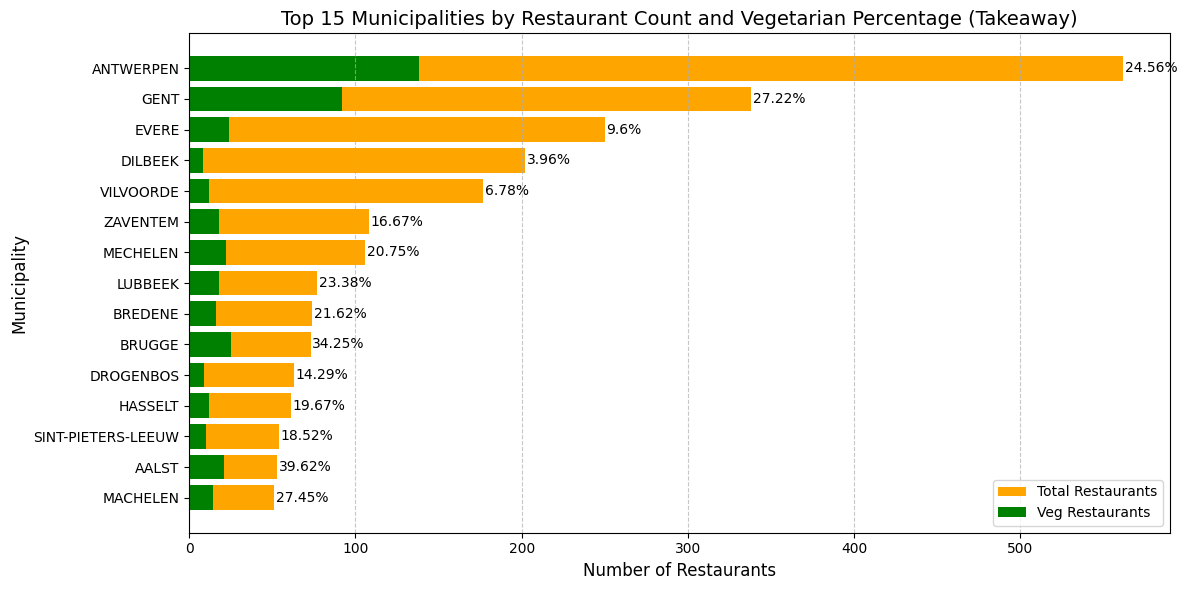

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"


# Connect to the database
conn = sqlite3.connect(db_path)

# Count unique restaurants and map to locations
restaurant_query = """
    SELECT 
        r.primarySlug AS restaurant_id,
        r.name AS restaurant_name,
        r.address AS restaurant_address,
        l.postalCode AS postal_code,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID;
"""
restaurant_data = pd.read_sql_query(restaurant_query, conn)

# Query to extract vegetarian and vegan dishes
veg_dish_query = """
    SELECT
        r.primarySlug AS restaurant_id,
        r.name AS restaurant_name,
        r.address AS restaurant_address,
        l.postalCode AS postal_code,
        mi.name AS dish_name,
        mi.description AS dish_description,
        c.name AS category
    FROM menuItems AS mi
    JOIN categories AS c ON mi.ID = c.item_id
    JOIN restaurants AS r ON mi.primarySlug = r.primarySlug
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%' OR c.name LIKE '%veg%';
"""
veg_dish_data = pd.read_sql_query(veg_dish_query, conn)

# Close the connection
conn.close()

# Remove duplicates to get accurate counts
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Normalize and clean postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract(r'(\d+)')
veg_dish_data['postal_code'] = veg_dish_data['postal_code'].astype(str).str.extract(r'(\d+)')
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract(r'(\d+)')

# Remap missing or '0' locations using the external postal codes dataset
remapped_restaurants_df = pd.merge(
    unique_restaurants,
    dutch_postal_codes_df[['Postcode', 'NAME', 'MAIN MUNICIPALITY', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Deduplicate to ensure unique restaurant IDs
remapped_restaurants_df = remapped_restaurants_df.drop_duplicates(subset=['restaurant_id'])

# Replace missing or '0' location names
remapped_restaurants_df['location_name'] = remapped_restaurants_df['location_name'].fillna(remapped_restaurants_df['NAME'])
remapped_restaurants_df.drop(columns=['Postcode', 'NAME'], inplace=True)

# Final count of unique restaurants
final_restaurant_count = len(remapped_restaurants_df)
print(f"Final count of unique restaurants after remapping: {final_restaurant_count}")

# Group by municipality and count restaurants
restaurants_per_municipality = remapped_restaurants_df.groupby('MAIN MUNICIPALITY')['restaurant_id'].count().reset_index()
restaurants_per_municipality.columns = ['Municipality', 'Restaurant Count']

# Map vegetarian and vegan dishes to municipalities
veg_dishes_per_municipality = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('MAIN MUNICIPALITY')['restaurant_id'].nunique().reset_index()
veg_dishes_per_municipality.columns = ['Municipality', 'Veg Restaurant Count']

# Combine municipality restaurant and vegetarian data
municipality_comparison_df = pd.merge(
    restaurants_per_municipality,
    veg_dishes_per_municipality,
    on='Municipality',
    how='left'
)
municipality_comparison_df['Veg Restaurant Count'] = municipality_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
municipality_comparison_df['Percentage Veg'] = (municipality_comparison_df['Veg Restaurant Count'] / municipality_comparison_df['Restaurant Count'] * 100).round(2)
municipality_comparison_df = municipality_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Print top municipalities with data
print("Top Municipalities with Vegetarian Data:")
print(municipality_comparison_df.head(15))

# Plot bar chart for top 15 municipalities
top_15_municipalities = municipality_comparison_df.head(15)
plt.figure(figsize=(12, 6))
bars = plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Restaurant Count'], color='orange', label='Total Restaurants')
plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, top_15_municipalities['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 15 Municipalities by Restaurant Count and Vegetarian Percentage (Takeaway)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Total number of unique restaurants: 4071


/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_23682/2297123984.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract(r'(\d+)')


Final count of unique restaurants after remapping: 4071


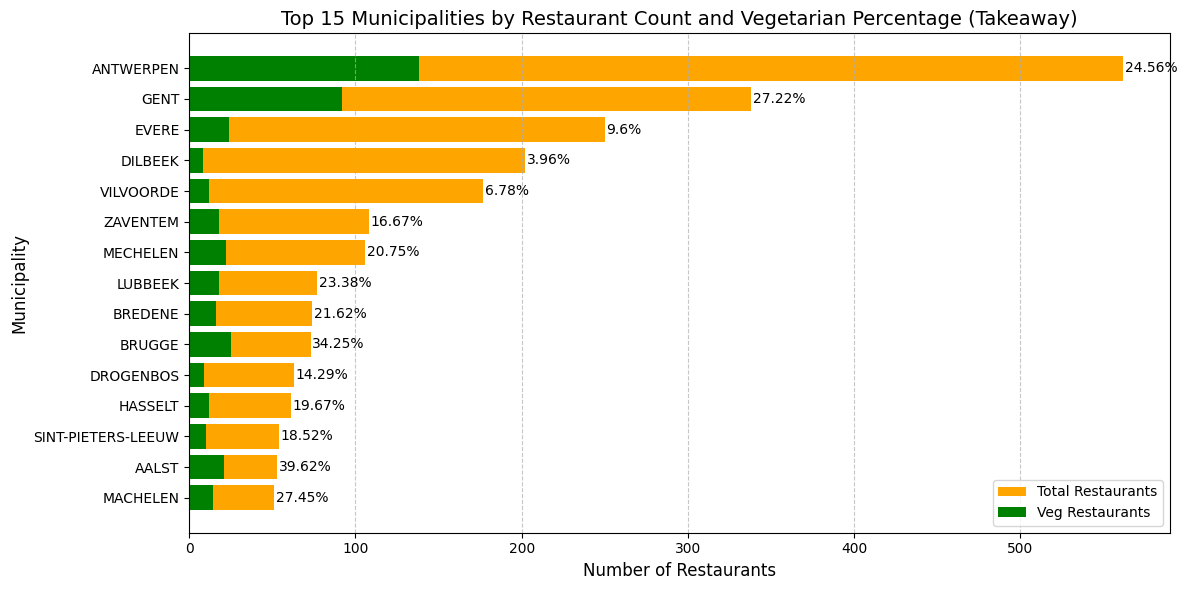

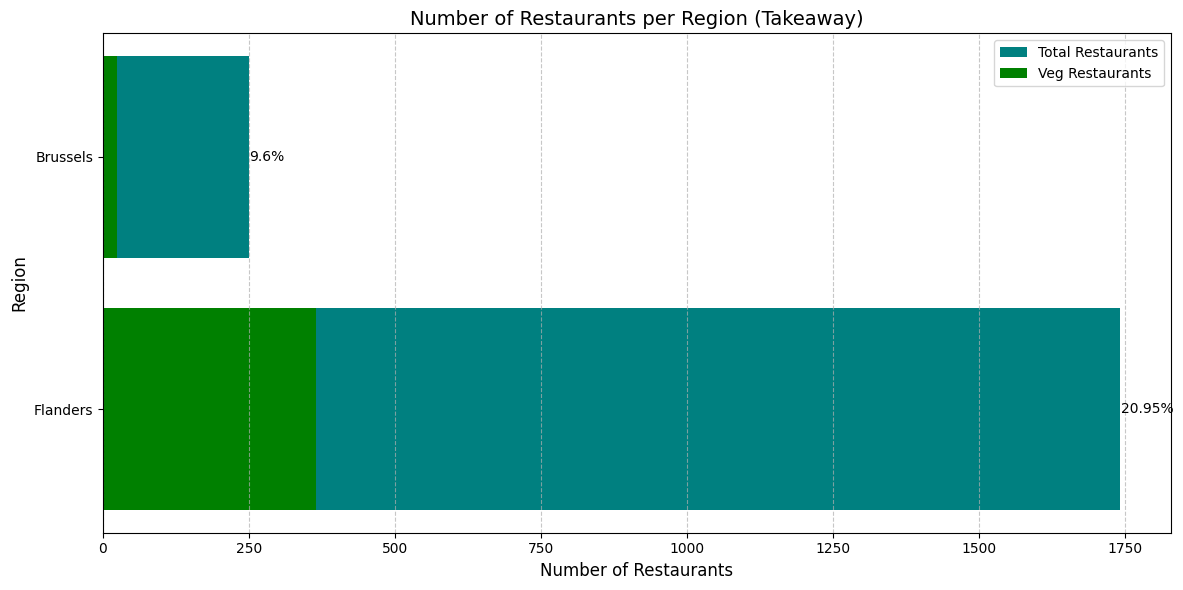

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"

# Connect to the database
conn = sqlite3.connect(db_path)

# Count unique restaurants and map to locations
restaurant_query = """
    SELECT 
        r.primarySlug AS restaurant_id,
        r.name AS restaurant_name,
        r.address AS restaurant_address,
        l.postalCode AS postal_code,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID;
"""
restaurant_data = pd.read_sql_query(restaurant_query, conn)

# Query to extract vegetarian and vegan dishes
veg_dish_query = """
    SELECT
        r.primarySlug AS restaurant_id,
        r.name AS restaurant_name,
        r.address AS restaurant_address,
        l.postalCode AS postal_code,
        mi.name AS dish_name,
        mi.description AS dish_description,
        c.name AS category
    FROM menuItems AS mi
    JOIN categories AS c ON mi.ID = c.item_id
    JOIN restaurants AS r ON mi.primarySlug = r.primarySlug
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID
    WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%' OR c.name LIKE '%veg%';
"""
veg_dish_data = pd.read_sql_query(veg_dish_query, conn)

# Close the connection
conn.close()

# Remove duplicates to get accurate counts
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Normalize and clean postal codes
unique_restaurants['postal_code'] = unique_restaurants['postal_code'].astype(str).str.extract(r'(\d+)')
veg_dish_data['postal_code'] = veg_dish_data['postal_code'].astype(str).str.extract(r'(\d+)')
dutch_postal_codes_df['Postcode'] = dutch_postal_codes_df['Postcode'].astype(str).str.extract(r'(\d+)')

# Remap missing or '0' locations using the external postal codes dataset
remapped_restaurants_df = pd.merge(
    unique_restaurants,
    dutch_postal_codes_df[['Postcode', 'NAME', 'MAIN MUNICIPALITY', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
)

# Deduplicate to ensure unique restaurant IDs
remapped_restaurants_df = remapped_restaurants_df.drop_duplicates(subset=['restaurant_id'])

# Replace missing or '0' location names
remapped_restaurants_df['location_name'] = remapped_restaurants_df['location_name'].fillna(remapped_restaurants_df['NAME'])
remapped_restaurants_df.drop(columns=['Postcode', 'NAME'], inplace=True)

# Final count of unique restaurants
final_restaurant_count = len(remapped_restaurants_df)
print(f"Final count of unique restaurants after remapping: {final_restaurant_count}")

# Group by municipality and count restaurants
restaurants_per_municipality = remapped_restaurants_df.groupby('MAIN MUNICIPALITY')['restaurant_id'].count().reset_index()
restaurants_per_municipality.columns = ['Municipality', 'Restaurant Count']

# Map vegetarian and vegan dishes to municipalities
veg_dishes_per_municipality = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'MAIN MUNICIPALITY']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('MAIN MUNICIPALITY')['restaurant_id'].nunique().reset_index()
veg_dishes_per_municipality.columns = ['Municipality', 'Veg Restaurant Count']

# Combine municipality restaurant and vegetarian data
municipality_comparison_df = pd.merge(
    restaurants_per_municipality,
    veg_dishes_per_municipality,
    on='Municipality',
    how='left'
)
municipality_comparison_df['Veg Restaurant Count'] = municipality_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
municipality_comparison_df['Percentage Veg'] = (municipality_comparison_df['Veg Restaurant Count'] / municipality_comparison_df['Restaurant Count'] * 100).round(2)
municipality_comparison_df = municipality_comparison_df.sort_values(by='Restaurant Count', ascending=False)

# Plot municipality-level data
top_15_municipalities = municipality_comparison_df.head(15)
plt.figure(figsize=(12, 6))
bars = plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Restaurant Count'], color='orange', label='Total Restaurants')
plt.barh(top_15_municipalities['Municipality'], top_15_municipalities['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, top_15_municipalities['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Municipality', fontsize=12)
plt.title('Top 15 Municipalities by Restaurant Count and Vegetarian Percentage (Takeaway)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Add regions based on postal codes (Flanders, Brussels, Wallonia)
def assign_region(postal_code):
    if pd.notnull(postal_code):
        postal_code = int(postal_code)
        if 1000 <= postal_code <= 1299:
            return 'Brussels'
        elif 1300 <= postal_code <= 1499 or 2000 <= postal_code <= 3999:
            return 'Flanders'
        elif 4000 <= postal_code <= 7999:
            return 'Wallonia'
    return None

remapped_restaurants_df['Region'] = remapped_restaurants_df['postal_code'].apply(assign_region)

# Group by region and count restaurants
restaurants_per_region = remapped_restaurants_df.groupby('Region')['restaurant_id'].count().reset_index()
restaurants_per_region.columns = ['Region', 'Restaurant Count']

# Map vegetarian and vegan dishes to regions
veg_dishes_per_region = pd.merge(
    veg_dish_data,
    remapped_restaurants_df[['postal_code', 'Region']],
    on='postal_code',
    how='left'
).groupby('Region')['restaurant_id'].nunique().reset_index()
veg_dishes_per_region.columns = ['Region', 'Veg Restaurant Count']

# Combine region restaurant and vegetarian data
region_comparison_df = pd.merge(
    restaurants_per_region,
    veg_dishes_per_region,
    on='Region',
    how='left'
)
region_comparison_df['Veg Restaurant Count'] = region_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
region_comparison_df['Percentage Veg'] = (region_comparison_df['Veg Restaurant Count'] / region_comparison_df['Restaurant Count'] * 100).round(2)

# Plot region-level data
plt.figure(figsize=(12, 6))
bars = plt.barh(region_comparison_df['Region'], region_comparison_df['Restaurant Count'], color='teal', label='Total Restaurants')
plt.barh(region_comparison_df['Region'], region_comparison_df['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, region_comparison_df['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title('Number of Restaurants per Region (Takeaway)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Group by province and count restaurants
restaurants_per_province = remapped_restaurants_df.groupby('Provincie')['restaurant_id'].count().reset_index()
restaurants_per_province.columns = ['Province', 'Restaurant Count']

# Map vegetarian and vegan dishes to provinces
veg_dishes_per_province = pd.merge(
    veg_dish_data,
    dutch_postal_codes_df[['Postcode', 'Provincie']],
    left_on='postal_code',
    right_on='Postcode',
    how='left'
).groupby('Provincie')['restaurant_id'].nunique().reset_index()


Total number of unique restaurants: 2729
Final count of unique restaurants: 2729


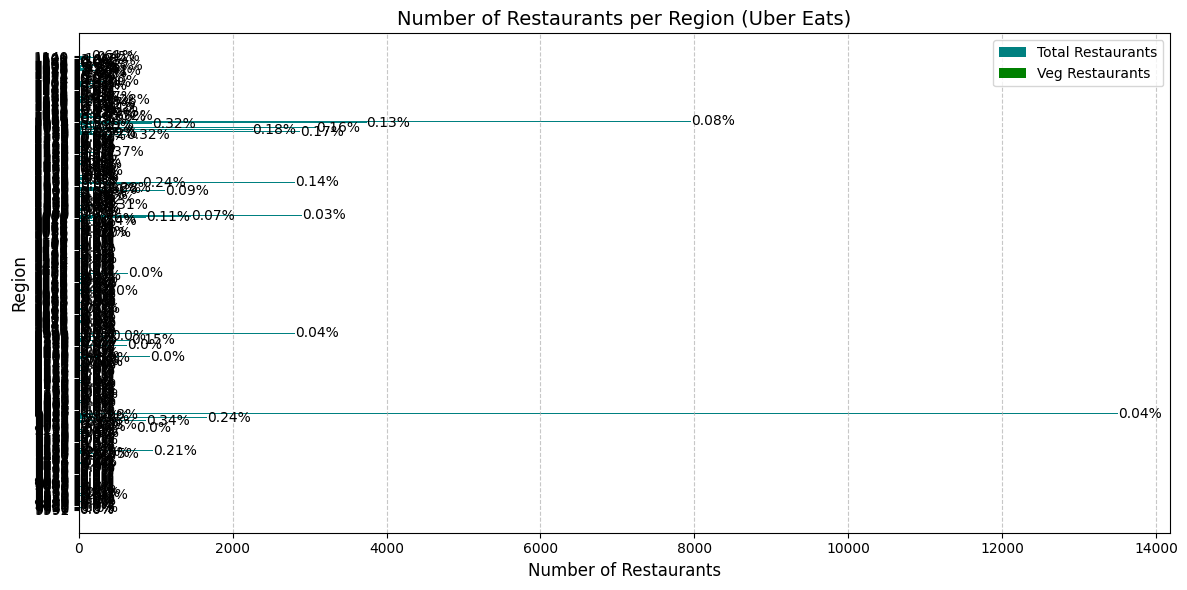

In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# File paths
db_path = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/ubereats.db"
dutch_postal_codes_file = "/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/CSV/FROM IMAD/zipcodes_num_nl_new_Tumi.xls"

# Connect to the database
conn = sqlite3.connect(db_path)

# Query to extract restaurant data with locations
restaurant_query = """
    SELECT 
        r.id AS restaurant_id,
        r.title AS restaurant_name,
        r.location__address AS restaurant_address,
        l.region AS region,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.id;
"""
restaurant_data = pd.read_sql_query(restaurant_query, conn)

# Query to extract vegetarian and vegan dishes
veg_dish_query = """
    SELECT
        r.id AS restaurant_id,
        r.title AS restaurant_name,
        r.location__address AS restaurant_address,
        l.region AS region,
        mi.name AS dish_name,
        mi.description AS dish_description,
        ms.title AS menu_section_title
    FROM menu_items AS mi
    JOIN menu_sections AS ms ON mi.menu_section_id = ms.id
    JOIN restaurants AS r ON mi.restaurant_id = r.id
    LEFT JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.id
    WHERE ms.title LIKE '%vegetarian%' OR ms.title LIKE '%vegan%' OR ms.title LIKE '%veg%';
"""
veg_dish_data = pd.read_sql_query(veg_dish_query, conn)

# Close the connection
conn.close()

# Remove duplicates to get accurate counts
unique_restaurants = restaurant_data.drop_duplicates(subset=['restaurant_id'])
total_restaurants = len(unique_restaurants)
print(f"Total number of unique restaurants: {total_restaurants}")

# Load the Dutch postal codes dataset (optional if regions are used directly)
dutch_postal_codes_df = pd.read_excel(dutch_postal_codes_file)

# Final count of unique restaurants
final_restaurant_count = len(unique_restaurants)
print(f"Final count of unique restaurants: {final_restaurant_count}")

# Group by region and count restaurants
restaurants_per_region = restaurant_data.groupby('region')['restaurant_id'].count().reset_index()
restaurants_per_region.columns = ['Region', 'Restaurant Count']

# Map vegetarian and vegan dishes to regions
veg_dishes_per_region = veg_dish_data.groupby('region')['restaurant_id'].nunique().reset_index()
veg_dishes_per_region.columns = ['Region', 'Veg Restaurant Count']

# Combine region restaurant and vegetarian data
region_comparison_df = pd.merge(
    restaurants_per_region,
    veg_dishes_per_region,
    on='Region',
    how='left'
)
region_comparison_df['Veg Restaurant Count'] = region_comparison_df['Veg Restaurant Count'].fillna(0).astype(int)
region_comparison_df['Percentage Veg'] = (region_comparison_df['Veg Restaurant Count'] / region_comparison_df['Restaurant Count'] * 100).round(2)

# Plot region-level data
plt.figure(figsize=(12, 6))
bars = plt.barh(region_comparison_df['Region'], region_comparison_df['Restaurant Count'], color='teal', label='Total Restaurants')
plt.barh(region_comparison_df['Region'], region_comparison_df['Veg Restaurant Count'], color='green', label='Veg Restaurants')
for bar, percentage in zip(bars, region_comparison_df['Percentage Veg']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{percentage}%', va='center')
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title('Number of Restaurants per Region (Uber Eats)', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [1]:
# Check the schema of the locations table
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(locations);")
columns = cursor.fetchall()
conn.close()

# Display the schema
for column in columns:
    print(column)


NameError: name 'sqlite3' is not defined

In [2]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap

# Paths to the database files
deliveroo_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/deliveroo.db'
takeaway_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'
ubereats_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/ubereats.db'

# Function to extract vegetarian/vegan restaurants from a database
def execute_query_with_custom_sql(db_path, query):
    conn = sqlite3.connect(db_path)
    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        df = None
        print(f"Error executing query on {db_path}: {e}")
    finally:
        conn.close()
    return df

# Custom SQL for Deliveroo
try:
    deliveroo_query = """
    SELECT r.name AS restaurant_name, r.latitude, r.longitude
    FROM restaurants r
    JOIN categories c ON r.id = c.restaurant_id
    WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%'
    """
    deliveroo_data = execute_query_with_custom_sql(deliveroo_path, deliveroo_query)
except:
    deliveroo_data = None

# Custom SQL for Takeaway
takeaway_query = """
SELECT
    r.primarySlug AS restaurant_name,
    r.latitude AS latitude,
    r.longitude AS longitude
FROM menuItems mi
JOIN categories c ON mi.id = c.item_id
JOIN restaurants r ON mi.primarySlug = r.primarySlug
WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%'
"""
takeaway_data = execute_query_with_custom_sql(takeaway_path, takeaway_query)

# Custom SQL for Uber Eats
ubereats_query = """
SELECT 
    r.title AS restaurant_name,
    r.location__latitude AS latitude,
    r.location__longitude AS longitude
FROM restaurants r
JOIN restaurant_to_categories rc ON r.id = rc.restaurant_id
WHERE rc.category LIKE '%vegetarian%' OR rc.category LIKE '%vegan%'
"""
ubereats_data = execute_query_with_custom_sql(ubereats_path, ubereats_query)

# Combine data from all sources
dataframes = [deliveroo_data, takeaway_data, ubereats_data]
combined_data = pd.concat([df for df in dataframes if df is not None], ignore_index=True)

# Filter out rows with missing latitude or longitude
combined_data = combined_data.dropna(subset=['latitude', 'longitude'])

# Create a heat map using Folium
map_center = [50.8503, 4.3517]  # Approximate center of Belgium
heat_map = folium.Map(location=map_center, zoom_start=8)

# Add restaurant locations to the heat map
heat_data = combined_data[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(heat_map)

# Save the heat map
heat_map.save("belgium_vegetarian_vegan_heatmap.html")


In [6]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap

# Paths to the database files
deliveroo_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/deliveroo.db'
takeaway_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/takeaway.db'
ubereats_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/delivery-market-analysis/databases/ubereats.db'

# Function to extract vegetarian/vegan restaurants from a database
def execute_query_with_custom_sql(db_path, query):
    conn = sqlite3.connect(db_path)
    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        df = None
        print(f"Error executing query on {db_path}: {e}")
    finally:
        conn.close()
    return df

# Custom SQL for Deliveroo
try:
    deliveroo_query = """
    SELECT r.name AS restaurant_name, r.latitude, r.longitude, r.postal_code
    FROM restaurants r
    JOIN categories c ON r.id = c.restaurant_id
    WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%'
    """
    deliveroo_data = execute_query_with_custom_sql(deliveroo_path, deliveroo_query)
    if deliveroo_data is not None:
        deliveroo_data['city'] = None  # Add a placeholder city column if missing
except:
    deliveroo_data = None

# Custom SQL for Takeaway
takeaway_query = """
SELECT
    r.primarySlug AS restaurant_name,
    r.latitude AS latitude,
    r.longitude AS longitude,
    l.postalCode AS postal_code,
    l.city AS city
FROM menuItems mi
JOIN categories c ON mi.id = c.item_id
JOIN restaurants r ON mi.primarySlug = r.primarySlug
LEFT JOIN locations_to_restaurants lr ON r.primarySlug = lr.restaurant_id
LEFT JOIN locations l ON lr.location_id = l.ID
WHERE c.name LIKE '%vegetarian%' OR c.name LIKE '%vegan%'
"""
takeaway_data = execute_query_with_custom_sql(takeaway_path, takeaway_query)

# Custom SQL for Uber Eats
ubereats_query = """
SELECT 
    r.title AS restaurant_name,
    r.location__latitude AS latitude,
    r.location__longitude AS longitude,
    r.location__postal_code AS postal_code,
    r.location__city AS city
FROM restaurants r
JOIN restaurant_to_categories rc ON r.id = rc.restaurant_id
WHERE rc.category LIKE '%vegetarian%' OR rc.category LIKE '%vegan%'
"""
ubereats_data = execute_query_with_custom_sql(ubereats_path, ubereats_query)

# Combine data from all sources
dataframes = [deliveroo_data, takeaway_data, ubereats_data]
combined_data = pd.concat([df for df in dataframes if df is not None], ignore_index=True)

# Filter out rows with missing latitude or longitude
combined_data = combined_data.dropna(subset=['latitude', 'longitude'])

# Ensure city column is consistent and handle NaN values
combined_data['city'] = combined_data['city'].fillna('Unknown').astype(str)

# Calculate percentage of vegan/vegetarian restaurants per city
city_totals = combined_data.groupby('city').size().reset_index(name='total_restaurants')
vegan_totals = combined_data[combined_data['city'] != 'Unknown'].groupby('city').size().reset_index(name='vegan_restaurants')
city_percentages = pd.merge(city_totals, vegan_totals, on='city', how='left').fillna(0)
city_percentages['vegan_percentage'] = (city_percentages['vegan_restaurants'] / city_percentages['total_restaurants']) * 100

# Create a Folium map
map_center = [50.8503, 4.3517]  # Approximate center of Belgium
folium_map = folium.Map(location=map_center, zoom_start=8)

# Add heat map layer
heat_data = combined_data[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(folium_map)

# Add markers with percentages
for _, row in city_percentages.iterrows():
    city_location = combined_data[combined_data['city'] == row['city']][['latitude', 'longitude']].dropna().mean()
    folium.Marker(
        location=[city_location['latitude'], city_location['longitude']],
        popup=(
            f"<strong>City:</strong> {row['city']}<br>"
            f"<strong>Total Restaurants:</strong> {row['total_restaurants']}<br>"
            f"<strong>Vegan/Vegetarian Percentage:</strong> {row['vegan_percentage']:.2f}%"
        ),
        icon=folium.Icon(color="green" if row['vegan_percentage'] > 50 else "red")
    ).add_to(folium_map)

# Save the map
folium_map.save("belgium_vegan_percentage_map.html")



TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [ ]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap

# Paths to the database files
deliveroo_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/Delivery/food_delivery-market-analysis/databases/deliveroo.db'
takeaway_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/Delivery/food_delivery-market-analysis/databases/takeaway.db'
ubereats_path = '/Users/irisvirus/Desktop/Becode/Python/Projects/Food_delivery_analysis/Delivery/food_delivery-market-analysis/databases/ubereats.db'

# Function to execute a SQL query and return a DataFrame
def execute_query(db_path, query):
    conn = sqlite3.connect(db_path)
    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        df = None
        print(f"Error executing query on {db_path}: {e}")
    finally:
        conn.close()
    return df

# SQL queries for each database
# Deliveroo query
try:
    deliveroo_query = """
    SELECT 
        r.id AS restaurant_id,
        r.latitude AS latitude,
        r.longitude AS longitude,
        r.postal_code AS postal_code,
        l.name AS location_name
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.id;
    """
    deliveroo_data = execute_query(deliveroo_path, deliveroo_query)
except:
    deliveroo_data = None

# Takeaway query
try:
    takeaway_query = """
    SELECT 
        r.primarySlug AS restaurant_id,
        r.latitude AS latitude,
        r.longitude AS longitude,
        l.postalCode AS postal_code,
        r.city AS city
    FROM restaurants AS r
    LEFT JOIN locations_to_restaurants AS lr ON r.primarySlug = lr.restaurant_id
    LEFT JOIN locations AS l ON lr.location_id = l.ID;
    """
    takeaway_data = execute_query(takeaway_path, takeaway_query)
except:
    takeaway_data = None

# Uber Eats query
try:
    ubereats_query = """
    SELECT 
        id AS restaurant_id,
        location__latitude AS latitude,
        location__longitude AS longitude,
        location__postal_code AS postal_code,
        location__city AS city
    FROM restaurants;
    """
    ubereats_data = execute_query(ubereats_path, ubereats_query)
except:
    ubereats_data = None

# Combine data from all sources
dataframes = [deliveroo_data, takeaway_data, ubereats_data]
combined_data = pd.concat([df for df in dataframes if df is not None], ignore_index=True)

# Filter out rows with missing latitude or longitude
combined_data = combined_data.dropna(subset=['latitude', 'longitude'])

# Create a Folium map for the heat map
map_center = [50.8503, 4.3517]  # Approximate center of Belgium
heat_map = folium.Map(location=map_center, zoom_start=8)

# Add heat map layer
heat_data = combined_data[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(heat_map)

# Save the heat map
heat_map.save("belgium_restaurant_heatmap.html")

# Create a Folium map for points
point_map = folium.Map(location=map_center, zoom_start=8)

# Add points for each restaurant
for _, row in combined_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
            f"<strong>Restaurant ID:</strong> {row['restaurant_id']}<br>"
            f"<strong>City:</strong> {row.get('city', 'N/A')}<br>"
            f"<strong>Postal Code:</strong> {row.get('postal_code', 'N/A')}"
        )
    ).add_to(point_map)

# Save the points map
point_map.save("belgium_restaurant_point_map.html")
